# PINN Damped Harmonic Oscillator 
This is a notebook is for my personal's learning purpose about PINN in simple Physics problem (with already known analytical solutions!) and I have taken codes from this [repo](https://github.com/benmoseley/harmonic-oscillator-pinn/tree/main) written by [Dr. Ben Moseley](https://github.com/benmoseley)

## Theoretical Background
The (1D) damped harmonic oscillator is described by the following ODE:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
This code focuses on the underdamped state where:
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
The well-known analytical solution yields:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

## Environment and Necessary Libraries
### Create Environment 
Install the necessary packages via `pinn_env.yml` 

### Librarires
We then import necessary libraries for our code as follows:

In [1]:
#%matplotlib ipympl
#For interactive plots
%matplotlib inline
#For inline plots

from PIL import Image #For our image saving/writing (https://pillow.readthedocs.io/en/stable/reference/Image.html)

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Define Neural Network
We then define a number of helper functions and our neural network as follows

In [8]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def oscillator(d, w0, x):
    "Defines the analytical solution to the 1D underdamped harmonic oscillator problem."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #We have chosen the activation function to be tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x) #Input Layers 
        x = self.fch(x) #Hidden layers
        x = self.fce(x) #Ending/Outout Layers
        return x

# Generating Training Data
From analytical solution, we can extract slice out points as our training dataset -> this can be replaced by actual experimental data of course for a wider/general case. However, for simplicity, here we make our PINN learn from some sparesly selected data points from analytical solution.

> We choose $\delta = 2$ and $\omega_0 = 20$

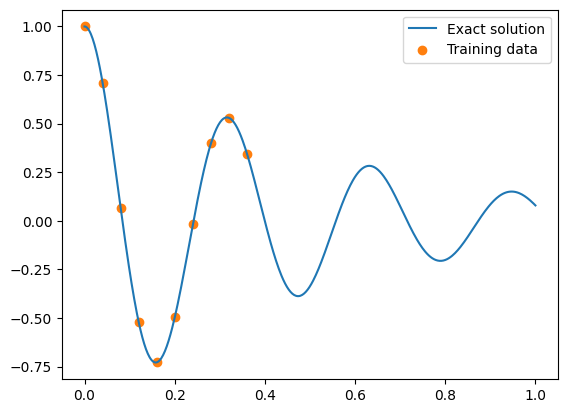

In [9]:
d, w0 = 2, 20 #Configuration constants for our Harmonic Oscillator 

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
#print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
#print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

> The above gave use an exact analytical solution plotted, as well as a scattered plot of training data

# "Naive" Neural Network
Then, now we consider a "naive" neural network where no Physics understanding is encoded into the loss function $\mathcal L$ 

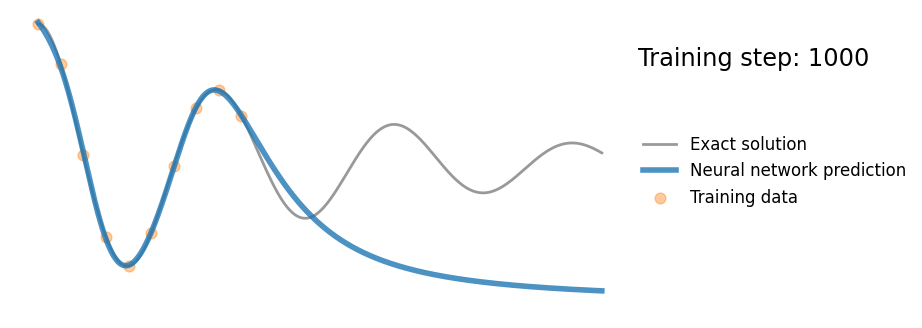

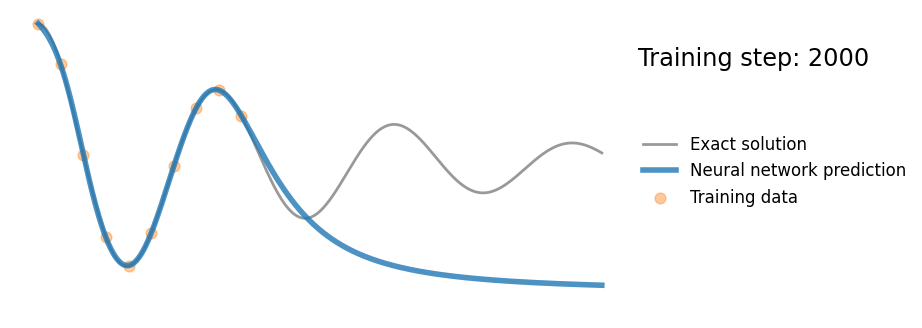

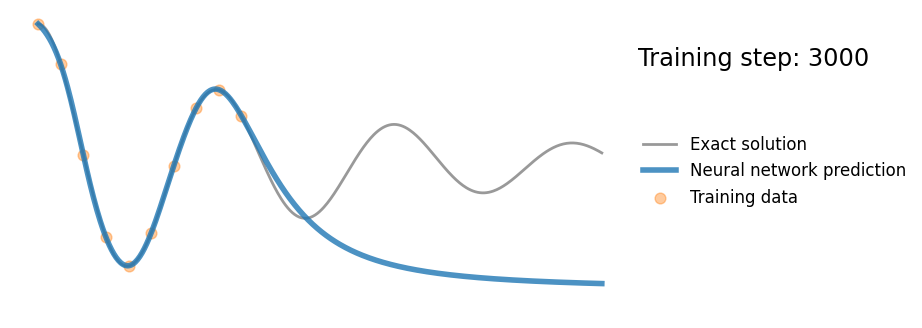

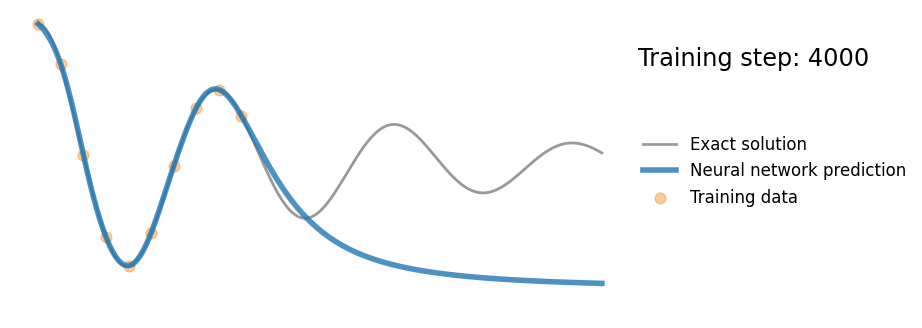

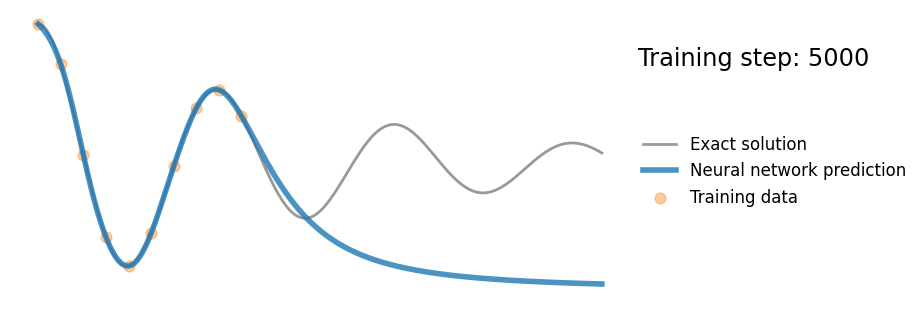

In [10]:
steps = 5000

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    
    
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3) 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) 
files = []
for i in range(steps): #loop between the neuron and the loss function for N times
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: #This saves a figure for every 10 steps 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 1000 == 0: #This shows the plot in steps
            plt.show() 
        else:
            plt.close("all")
            
save_gif_PIL("nn.gif", files, fps=20, loop=0)

The animation is shown below:
![Animation](nn.gif)

# PINN
> For a Physics-Informed Neural Network, as the name suggests, we have to "inform" the neural network with knowledge of Physics. This  is done via the loss function $\mathcal L$

We know the following the governing ODE
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0
$$
Hence we can use this to form 2 additional loss functions in addition to the previous mean squared difference $\frac{1}{N}\sum^N_{i=1}(x_i - x_{data})^2$:
1) From ODE:
$$
\mathcal{L} = \lambda \frac{1}{N}\sum^N_{i=1} \bigg[\dfrac{d^2x}{dt^2}+\mu \dfrac{dx}{dt}+kx - 0 \bigg]^2
$$
for some weight $\lambda$ which we have chosen to be 0.0001 -> This needs to be found by trial
We try to minise the mean squared difference from the neuron's prediction gone through the ode to the actual solution of 0 (remember our governing ODE is a homogenous case).

For a non homogenous solution where the ODE equals to some other function $f(t)$, then:
$$
\mathcal{L} = \lambda \frac{1}{N}\sum^N_{i=1} \bigg[\dfrac{d^2x}{dt^2}+\mu \dfrac{dx}{dt}+kx - f(t) \bigg]^2
$$

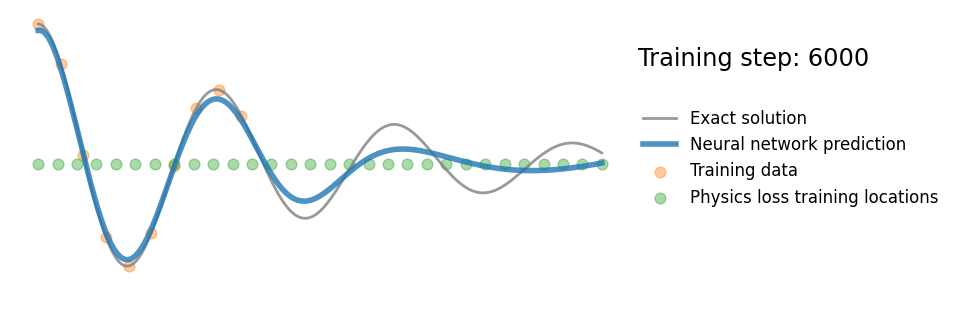

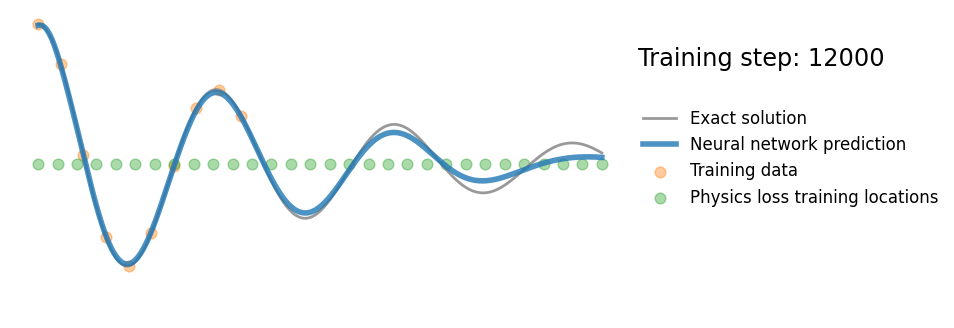

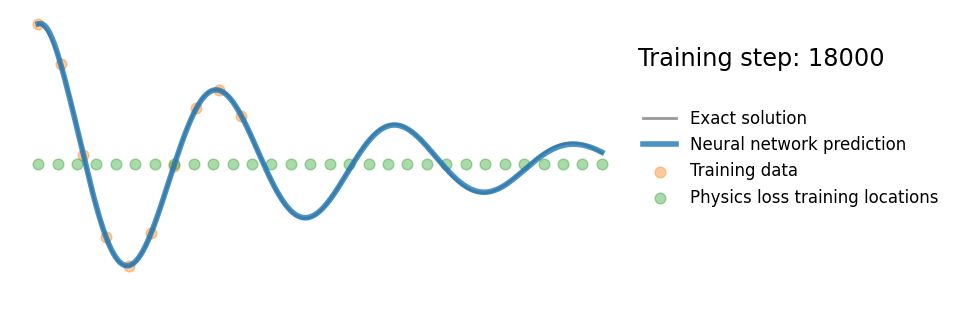

In [11]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)

Here's the animation
![animation](pinn.gif)

# Summary 

Here we summarise the workflow/process of a PINN:
1) Training Data
   * through slicing through a known result;
   * through experimental data
2) Define Neural Network
   * Define a `class` object "FCN" (Fully Connected Network) using `nn.Modules`
   * Within your FCN, we define
        * Activation Function - $\tanh()$ is good as it is twice differentiable (and further!)
        * self.fcs() - Input Layer
        * self.fch() - Hidden Layer
        * self.fce() - Output Layer
3) Calling the Neural Network
```Python
torch.manual_seed(123) #for fixing seed 
model = FCN(1,1,32,3) #calling the model 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) #calling the optimizer (Adam)
```
Note: the `lr` argument is the learning rate, typically for Adam, we can choose `lr = 1e-4`

4) Define and Loss Function
   * Typical Neural Network: mean squared difference
$$
\frac{1}{N}\sum^N_{i=1}(x_i - x_{data})^2
$$
    * Physics informed Neural Network (PINN) would also take in additional functions to minimise. For example:
        * Differential Equations
        * Initial Conditions
        * Boundary Conditions
        * Normalisation Conditions
5) Training
    * The neurons are then trained for N times by looping between the optimiser and the loss function
    * We expect the neurons to minise loss function every time it is being trained
6) Output
    * Finally, we now have a result :) 